In [1]:
import os

root_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
os.chdir(root_dir)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import functions
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.6)



# Kyte & Doolittle index of hydrophobicity
# J. Mol. Biol. 157:105-132(1982).
kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
      "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
      "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
      "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2}

#Sort kd
kd = {k: v for k, v in sorted(kd.items(), key=lambda item: item[1])}
aa = [k for k,v in kd.items()]

%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_pickle('results/signalp5_train_all.pkl.gz')
df.head(2)

,Entry,All,Protein,Entry name,Status,Protein names,Gene names,Organism,Length,Signal peptide,...,Cross-reference (Pfam),Biotechnological use,Motif,Domain [FT],Cross-reference (InterPro),Cross-reference (PROSITE),Cleavage,Accession,Label,Aligned
0,Q92791,sp|Q92791|SC65_HUMAN Endoplasmic reticulum pro...,MARVAWGLLWLLLGSAGAQYEKYSFRGFPPEDLMPLAAAYGHALEQ...,SC65_HUMAN,reviewed,Endoplasmic reticulum protein SC65 (Leprecan-l...,P3H4 LEPREL4 NOL55 SC65,Homo sapiens (Human),437,"SIGNAL 1..18; /evidence=""ECO:0000255""",...,NaN,NaN,NaN,NaN,IPR033213;,NaN,18.0,Q92791|EUKARYA|NO_SP|1,1,__MARVAWGLLWLLLGSAGAQYEKYSFRGFPPEDLMPLAAA
1,B0JFB8,sp|B0JFB8|FPI1_ANTMY Fungal protease inhibitor...,MKAVITLLFLACILVVTYGDLICGTNYCKDHPCTSPIARASCRSPA...,FPI1_ANTMY,reviewed,Fungal protease inhibitor-1,fpi-1,Antheraea mylitta (Tasar silkworm),105,"SIGNAL 1..19; /evidence=""ECO:0000269|PubMed:1...",...,PF12190;,NaN,NaN,NaN,IPR021066;,NaN,19.0,B0JFB8|EUKARYA|SP|0,1,_MKAVITLLFLACILVVTYGDLICGTNYCKDHPCTSPIARA


In [4]:
kingdoms = ['Metazoa', 'Fungi', 'Viridiplantae', ]
dfs_nocluster = []
for i, v in enumerate(kingdoms):
    #Cluster
    s = df[df['Taxonomic lineage (KINGDOM)'].apply(lambda x: x == v)].copy()

    dfs_nocluster.append(s)
print('No cluster')
for p, q in enumerate(dfs_nocluster):
    print(kingdoms[p]+'\n----------')
    print(q.Label.value_counts())
    print('---------')

No cluster
Metazoa
----------
0    7388
1    2187
Name: Label, dtype: int64
---------
Fungi
----------
0    4081
1     131
Name: Label, dtype: int64
---------
Viridiplantae
----------
0    2981
1     260
Name: Label, dtype: int64
---------


In [5]:
from subprocess import run, PIPE, DEVNULL

kingdoms = ['Metazoa', 'Fungi', 'Viridiplantae', ]
dfs = []
for i, v in enumerate(kingdoms):
    #Cluster
    s = df[df['Taxonomic lineage (KINGDOM)'].apply(lambda x: x == v)].copy()

    cl = s[['Entry', 'Protein']].copy()
    cl['Entry'] = '>' + cl['Entry']
    cl['Protein'] = cl['Protein'].str[:60]
    
    fname = 'results/{}.fa'.format(kingdoms[i])
    clust_fname = 'results/{}_cluster.fa'.format(kingdoms[i])
    cl.to_csv(fname, sep='\n', index=None, header=None)

    all_args = ['cd-hit', '-i', fname, '-o', clust_fname, '-n', '5', '-c', '0.7']

    run(all_args, stdout=PIPE, stderr=DEVNULL, encoding='utf-8')

    clustered = functions.fasta_reader(clust_fname)
    
    new_df = s[s['Entry'].apply(lambda x: x in clustered.Accession.values)]
    new_df = new_df.reset_index(drop=True)
    
    
    dfs.append(new_df)
#     dfs.append(s.copy())

for p, q in enumerate(dfs):
    print(kingdoms[p]+'\n----------')
    print(q.Label.value_counts())
    print('---------')

Metazoa
----------
0    6321
1    1594
Name: Label, dtype: int64
---------
Fungi
----------
0    4000
1     121
Name: Label, dtype: int64
---------
Viridiplantae
----------
0    2754
1     220
Name: Label, dtype: int64
---------


In [6]:
def bitscore(df, col):
    if col == 'Protein':
        prob_ = pd.DataFrame(columns=np.arange(1, 61), index=aa)
    else:
        prob_ = pd.DataFrame(columns=np.arange(1, 31), index=aa)

    model = df[df.Label == 1].copy()
    background = df[df.Label == 0].copy()

    dfs_ = []
    for m in [model, background]:
        if col == 'Protein':
            hmm_df = m[col].str[:60].str.split('', expand=True)[np.arange(1, 61)]
        else:
            hmm_df = m[col].str[5:-6].str.split('', expand=True)[np.arange(1, 31)]
        for i in hmm_df.columns:
            all_counts = hmm_df[i].value_counts()
            for amino in aa:
                try:
                    prob_.loc[amino, i] = all_counts[amino]/all_counts.sum()
                except Exception:
                    prob_.loc[amino, i] = np.nan
        weights = prob_.fillna(0.0000001)
        dfs_.append(weights)
    ww = np.log2(dfs_[0]/dfs_[1])
    if col != 'Protein':
        ww.columns=np.setdiff1d(np.arange(-15, 16, 1), np.array([0]))
    return ww

In [7]:
bitscores = [bitscore(i, 'Protein') for i in dfs]
bitscores_cleavage = [bitscore(i, 'Aligned') for i in dfs]

In [142]:
# plt.figure(figsize=(10, 10))
# sns.set_context("paper", font_scale=1.2)
# sns.heatmap(bitscores[3][np.arange(1, 31)], cmap="RdBu_r", center=0); # vmin=-15, vmax=8,

In [143]:
# np.log2(toxins[toxins.Label==1]['Protein'].apply(lambda x: x[0]).value_counts() * 1738/(toxins[toxins.Label==0]['Protein'].apply(lambda x: x[0]).value_counts() * 261))

In [144]:
# np.log2(dfs[3][dfs[3].Label==1]['Protein'].apply(lambda x: x[0]).value_counts()* 1738/(dfs[3][dfs[3].Label==0]['Protein'].apply(lambda x: x[0]).value_counts()* 261))

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


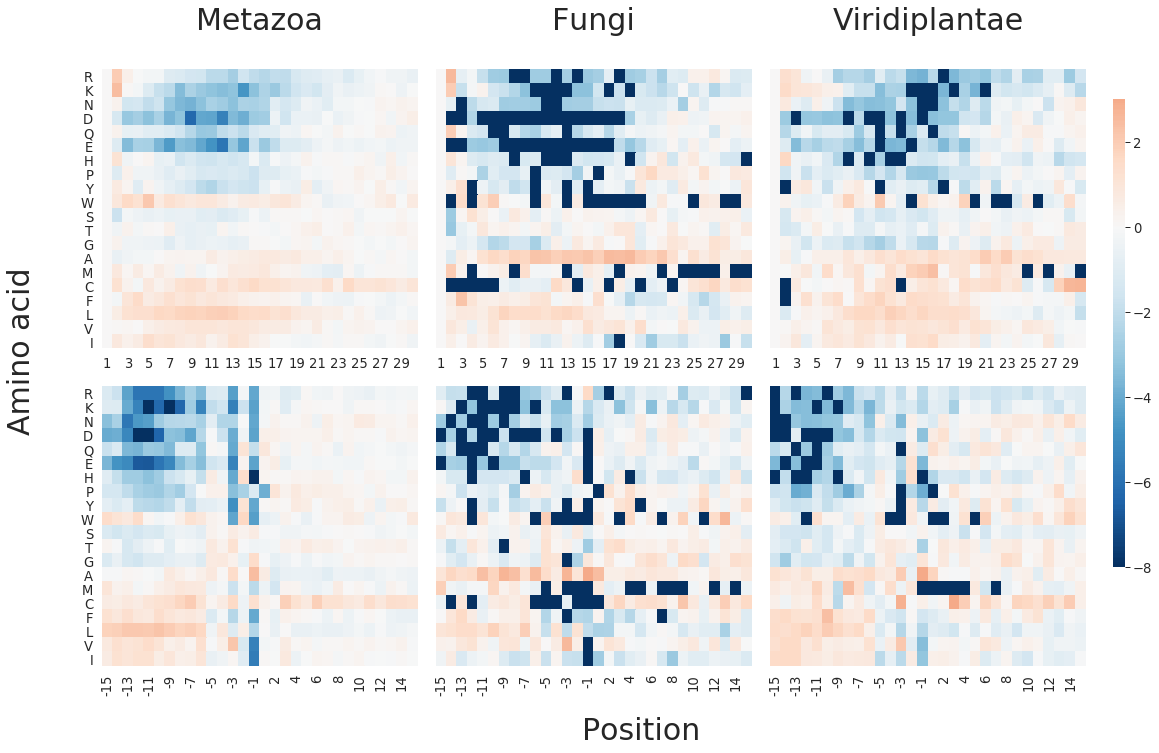

In [12]:
sns.set_context("paper", font_scale=1.5)
fig, axn = plt.subplots(nrows=2, ncols=3, figsize=(16, 10), sharey=True)
cbar_ax = fig.add_axes([0.91, .2, .01, .65])

all_bitscores = [a[np.arange(1, 31)] for a in bitscores] + bitscores_cleavage

for i, ax in enumerate(axn.flat):
    sns.heatmap(all_bitscores[i], ax=ax,
                cbar=i == 0,
                vmin=-8, vmax=3,
                cbar_ax=None if i else cbar_ax,
                cmap='RdBu_r',
               center=0, 
               yticklabels=aa)
    if i < len(kingdoms):
        ax.set_title(kingdoms[i]+'\n', fontsize=30)
    plt.sca(ax)


fig.text(0.5, -0.04, 'Position', ha='center', fontsize=30)
fig.text(-0.05, 0.5, 'Amino acid', va='center', rotation='vertical', fontsize=30)
fig.tight_layout(rect=[0, 0, 0.9, 1])
# plt.savefig('figs/bitscore_heatmap.pdf',  bbox_inches='tight', pad_inches=0)

In [19]:
toxins = pd.read_pickle('results/toxin_nontoxin.pkl.gz')


# dfs.append(toxins)
# kingdoms.append('Toxins') #Not kingdom but whatever

toxins.Label.value_counts()

0    1738
1     261
Name: Label, dtype: int64

In [21]:
bitscore_tox = [bitscore(toxins, 'Protein')]
bitscore_cleavage_tox = [bitscore(toxins, 'Aligned')]

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


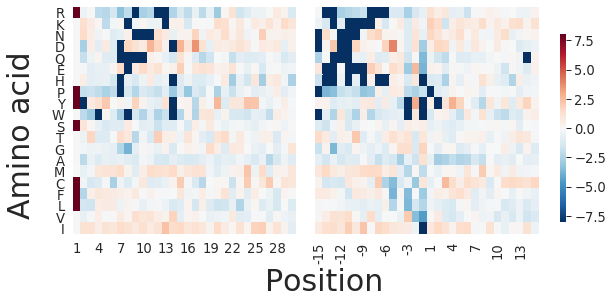

In [32]:
sns.set_context("paper", font_scale=1.5)
fig, axn = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)
cbar_ax = fig.add_axes([0.91, .2, .01, .65])

all_bitscores = [a[np.arange(1, 31)] for a in bitscore_tox] + bitscore_cleavage_tox

for i, ax in enumerate(axn.flat):
    sns.heatmap(all_bitscores[i], ax=ax,
                cbar=i == 0,
                vmin=-8, vmax=8,
                cbar_ax=None if i else cbar_ax,
                cmap='RdBu_r',
               center=0, 
               yticklabels=aa)
#     if i < len(kingdoms):
#         ax.set_title(kingdoms[i]+'\n', fontsize=30)
    plt.sca(ax)


fig.text(0.5, -0.04, 'Position', ha='center', fontsize=30)
fig.text(-0.05, 0.5, 'Amino acid', va='center', rotation='vertical', fontsize=30)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('figs/bitscore_heatmap_toxin.pdf',  bbox_inches='tight', pad_inches=0)

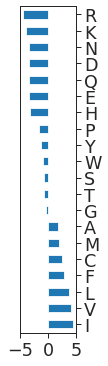

In [14]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=2)
ax = pd.DataFrame(kd, index=[0]).transpose().sort_values(by=0, ascending=False).plot(kind='barh', figsize=(1, 6), legend=None)
plt.xticks([-5, 0, 5])
ax.yaxis.tick_right()
# sns.despine()
plt.savefig('figs/hydrophobicity.pdf', bbox_inches='tight', pad_inches=0)
